# Закономерности, определяющие успешность игры

Интернет-магазин «Стримчик» продаёт по всему миру компьютерные игры. 

Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). 

**Задачи**:

- выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.
- спрогнозировать продажи на следующий год.
- проверить гипотезы, касаемые рейтинга игр.

**Входные данные**:
* Данные по играм до 2016 года.

В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

## Изучение данных из файла

Импортируем необходимые библиотеки:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from datetime import datetime as dt
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

import plotly.io as pio
pio.renderers.default='notebook'

Откроем датасет, сохраним его в переменную

In [2]:
try:
    df = pd.read_csv('/datasets/games.csv')
except:
    df = pd.read_csv('games.csv')
    
pd.options.display.max_columns = 50

### Вывод и описание данных
Просмотрим 5 случайных строк датасета:

In [3]:
df.sample(5)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
13649,Zombi Daisuki,DS,2011.0,Action,0.00,0.00,0.04,0.00,NaN,NaN,NaN
12809,Champion Jockey: G1 Jockey & Gallop Racer,X360,2011.0,Sports,0.00,0.05,0.00,0.01,NaN,NaN,NaN
16105,Cosmetic Paradise: Make no Kiseki,DS,2008.0,Misc,0.00,0.00,0.01,0.00,NaN,NaN,NaN
2315,Skylanders: Trap Team,X360,2014.0,Action,0.54,0.27,0.00,0.08,NaN,tbd,E10+
2904,Star Wars: Obi-Wan,XB,2001.0,Action,0.52,0.16,0.00,0.02,58.0,5.9,T


**Описание данных:**

    Name — название игры
    Platform — платформа
    Year_of_Release — год выпуска
    Genre — жанр игры
    NA_sales — продажи в Северной Америке (миллионы проданных копий)
    EU_sales — продажи в Европе (миллионы проданных копий)
    JP_sales — продажи в Японии (миллионы проданных копий)
    Other_sales — продажи в других странах (миллионы проданных копий)
    Critic_Score — оценка критиков (максимум 100)
    User_Score — оценка пользователей (максимум 10)
    Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг       компьютерных игр и присваивает им подходящую возрастную категорию.

### Сводная информация
Посмотрим сводную информацию о датафрейме:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


### Пропущенные значения

Посмотрим на количество пропущенных значений, а также посчитаем их процент по столбцам:

In [5]:
def nan_values(df):
    count_missing = df.isna().sum()
    percent_missing = round(df.isna().sum() * 100 / len(df), 2)
    
    missing_value_df = pd.DataFrame({'num_missing': count_missing,
                                     'percent_missing': percent_missing})
    
    return missing_value_df

nan_values(df)

,num_missing,percent_missing
Name,2,0.01
Platform,0,0.00
Year_of_Release,269,1.61
Genre,2,0.01
NA_sales,0,0.00
EU_sales,0,0.00
JP_sales,0,0.00
Other_sales,0,0.00
Critic_Score,8578,51.32
User_Score,6701,40.09


### Явные дубликаты

Проверим таблицу на наличие явных дубликатов:

In [6]:
print('Количество дубликатов равно', df.duplicated().sum())

Количество дубликатов равно 0


### Выводы

* Названия столбцов таблицы нужнаются в переименовании;
* Данные столбцов следуе привести к другому типу;
* В таблице есть пропуски, их неоходимо заполнить;
* В датафрейме отсутствуют явные дубликаты.

## Подготовка данных

Переименуем название столбцов:

In [7]:
df.columns = df.columns.str.lower()

Займёмся пропусками значений и приведением их к нужным типам

In [8]:
# Удаляем отсутствующие значения столбца year_of_release. Восстанавлявать столь малый процент (1.61) не имеет смысла.

df = df.dropna(subset=['year_of_release'])
df['year_of_release'] = df['year_of_release'].astype(np.int64)

# По тем же причинам удаляем строки с отсутвием названия игры

df = df.dropna(subset=['name'])

В столбце с оценками пользователей присутствует аббревиаура *tbd*, дословные расшифровка и перевод которой - to be determined, "пока не определён". 

К сожалению, поскольку данные были собраны из открытых источников, то их полнота находится под сомнением. Заменим все оставшиеся пропуски на *unknown*

In [9]:
df.loc[df['user_score'] == 'tbd', 'user_score'] = 'unknown'
df = df.fillna('unknown')

Посчитаем суммарные продажи во всех регионах и запишем в столбец *world_sales*

In [10]:
df['world_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']

### Выводы

По итогам подготовки данных:

* Переименовали названия столбцов
* Удалили строки с отсутсвующим годом выпуска
* Дали определение аббревиауре tbd
* Заполнили оставшиеся пропуски на unknown

## Исследовательский анализ данных

### Количество игр по годам

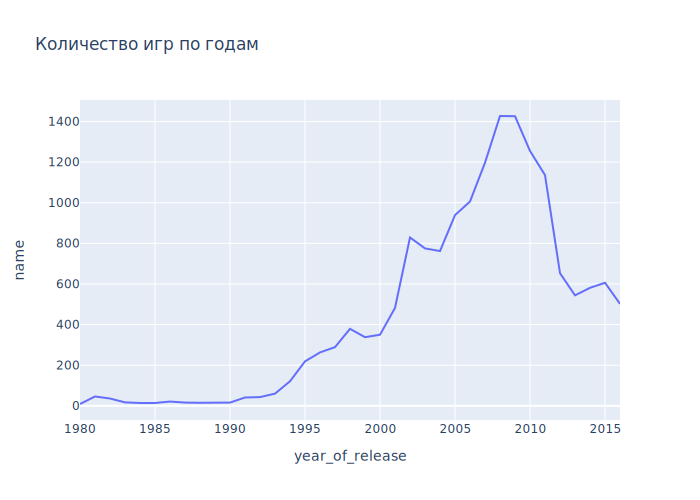

In [11]:
games_by_years = df.pivot_table(index='year_of_release', values='name', aggfunc='count').reset_index()
fig = px.line(games_by_years, x='year_of_release', y='name', title='Количество игр по годам')
fig.show('svg')

#### Выводы

* До 1990 года игры выходили относительно равномерно и в небольшом количестве
* С 1991 года наблюдается резкий подём в игровой инустрии
* Пик по выпуску игр приходится на 2008-2009 годы. В то время были популярны короткие, зачастую некачественные игры. Рынок был переполнен количеством игровых студий. Однако после кризиса этих лет игровой индустрии пришлось пережить тяжёлые времена, закрытия компаний. Отсюда и резкий спад.

### Продажи по платформам

In [12]:
# Определяем топ-5 платформ с наибольшии суммарными продажами за всё время

top_platform_names = df.groupby(['platform']) \
                       .agg({'world_sales': 'sum'}) \
                       .reset_index() \
                       .sort_values('world_sales', ascending=False) \
                       .head(5)


top_platform_names

,platform,world_sales
16,PS2,1233.56
28,X360,961.24
17,PS3,931.34
26,Wii,891.18
4,DS,802.78


#### Платформы-лидеры продаж

В топ-5 платформ - лидеров продаж за всё время попали:
* 1) PS2
* 2) X360
* 3) PS3
* 4) Wii
* 5) DS

In [13]:
top_platform = df.pivot_table(index=['platform'], values='world_sales', aggfunc='sum') \
                 .sort_values(by='world_sales') \
                 .query('world_sales > 80')

In [14]:
counts_by_platform = df.groupby(['platform', 'year_of_release']) \
                       .agg({'name': 'count'}) \
                       .reset_index()

In [15]:
sales_by_platform = df.groupby(['platform', 'year_of_release']) \
                       .agg({'world_sales': 'sum'}) \
                       .reset_index()

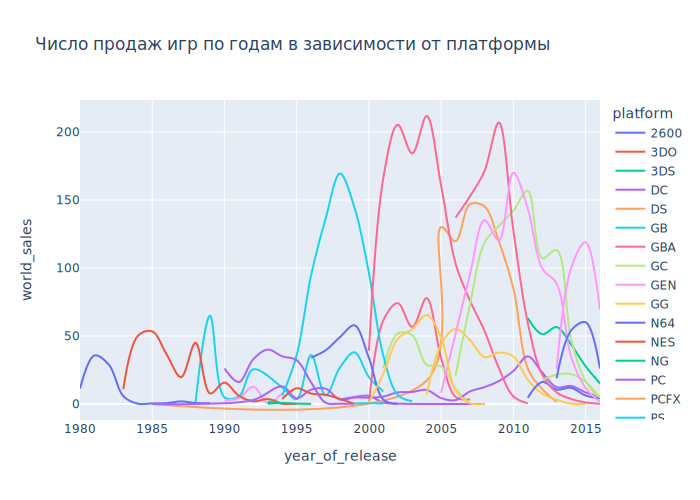

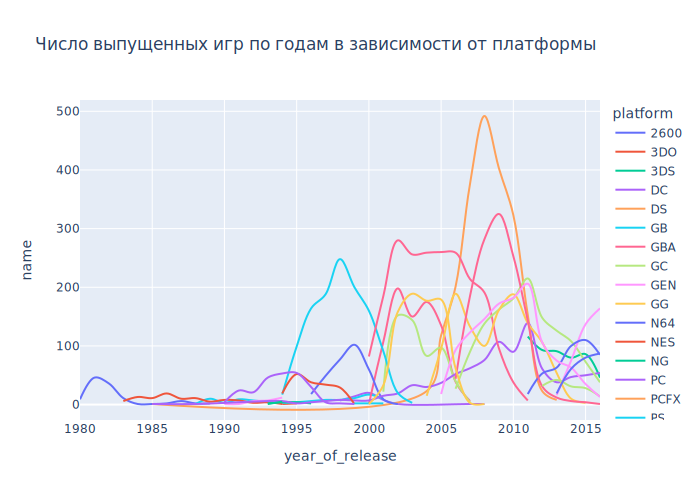

In [16]:
fig = px.line(sales_by_platform, x="year_of_release", y="world_sales",
              color="platform", line_group="platform", hover_name="platform",
              line_shape="spline", render_mode="svg",
              title='Число продаж игр по годам в зависимости от платформы')
fig.show('svg')

fig = px.line(counts_by_platform, x="year_of_release", y="name",
              color="platform", line_group="platform", hover_name="platform",
              line_shape="spline", render_mode="svg", title='Число выпущенных игр по годам в зависимости от платформы')
fig.show('svg')

#### Выводы

Со временем число продаж вполне закономерно возрастало и падало. Одни платформы приходили на смену другим. Что-то оставалось в тренде в долгосрочной перспективе, что-то быстро "затухало".

Строить перспективы по сильно устаревшим данным будет неправильно, а потому лучше взять более актуальный период: 2-3 последних года (2013-2014 г.)

### Анализ актуального периода

In [17]:
# Записываем в отдельную переменную актуальные данные

dfa = df.query('year_of_release >= 2014')

**Анализ доходов современных платформ**

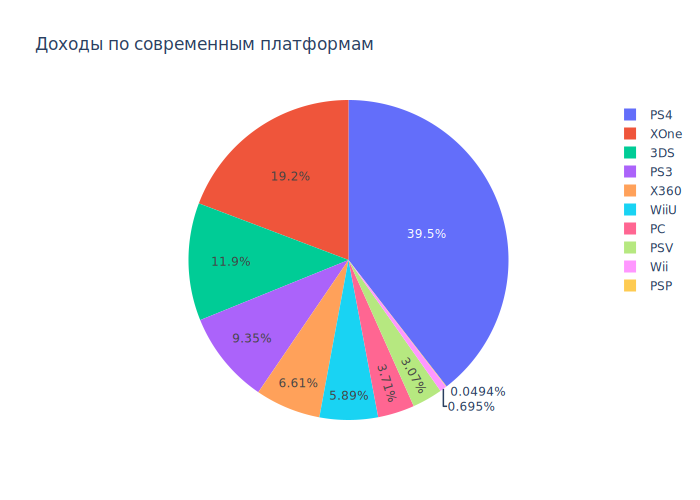

In [56]:
new_sales = dfa.pivot_table(index='platform', values='world_sales', aggfunc='sum').reset_index().sort_values(by='world_sales')
fig = px.pie(new_sales, values='world_sales', names='platform', title='Доходы по современным платформам')
fig.show('svg')

In [52]:
top_platform_a = dfa.pivot_table(index=['platform'], values='world_sales', aggfunc='sum') \
                 .sort_values(by='world_sales')

In [20]:
sales_by_platform_a = dfa.groupby(['platform', 'year_of_release']) \
                       .agg({'world_sales': 'sum'}) \
                       .reset_index()

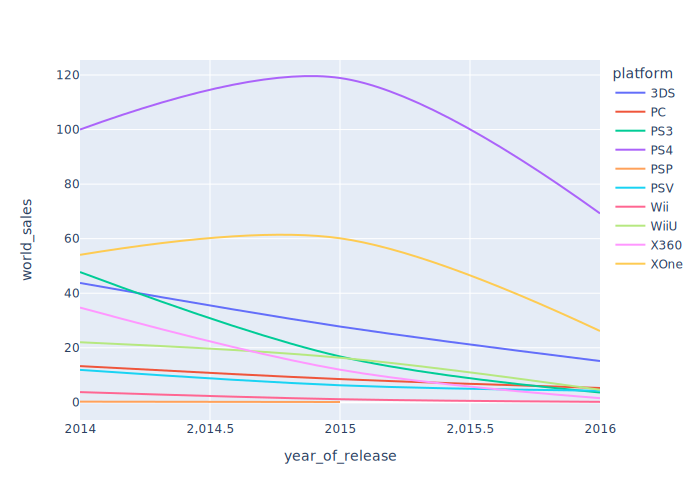

In [21]:
fig = px.line(sales_by_platform_a, x="year_of_release", y="world_sales",
              color="platform", line_group="platform", hover_name="platform",
              line_shape="spline", render_mode="svg")
fig.show('svg')

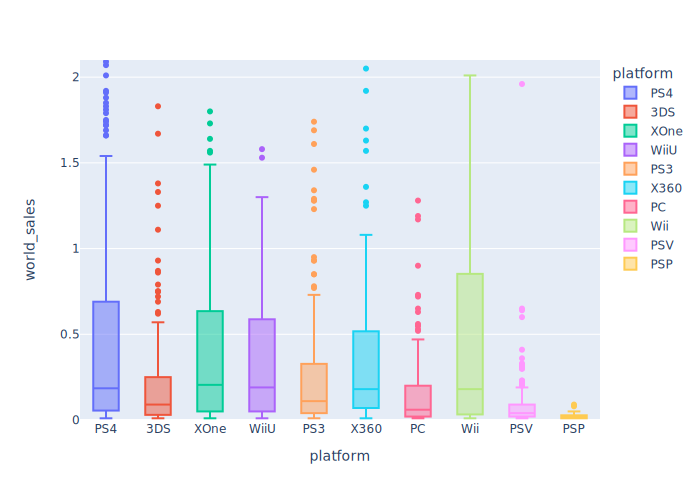

In [22]:
fig = px.box(dfa, x="platform", y="world_sales", color="platform", range_y=(0,2.1))
fig.show('svg')

#### Выводы

* Несомненным лидером продаж являются наиболее новые платформы. Наибольшую прибыль получает платформа PS (39.5%):
* У всех платформ наблюдается спад продаж. Чем больше компания платформы, тем ощутимей спад;
* Нельзя точно сказать о потенциально прибыльных платформах.

### Продажи самой популярной платформы

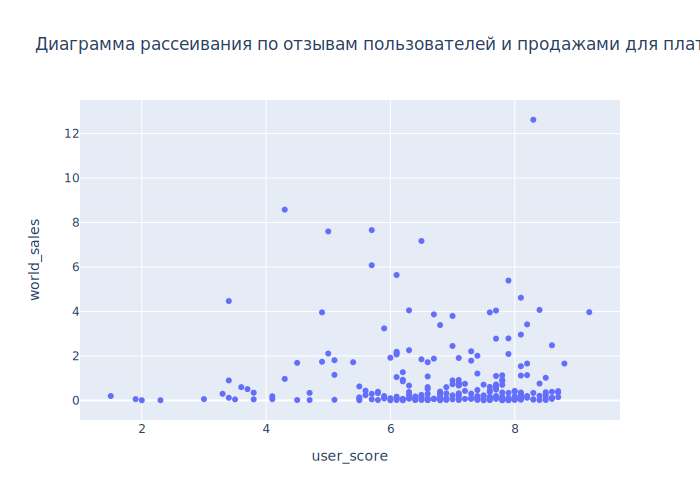

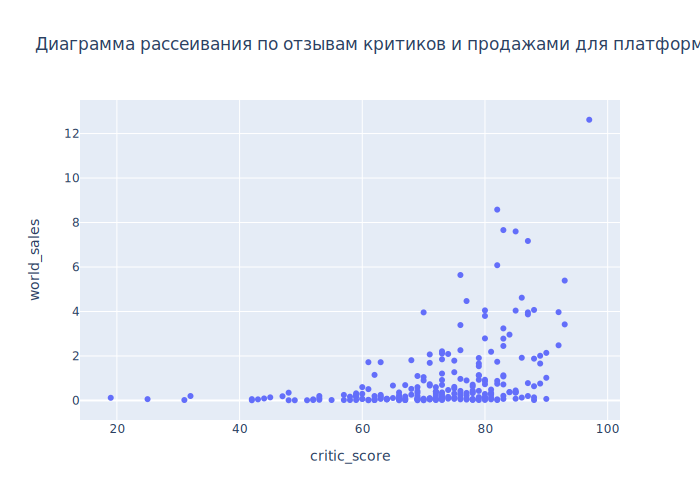

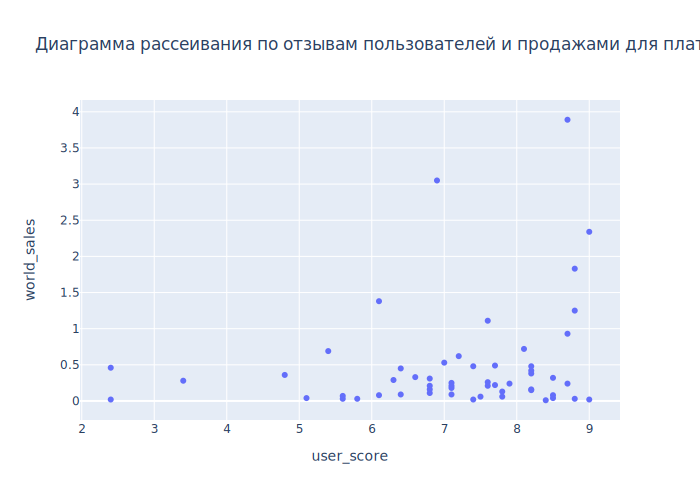

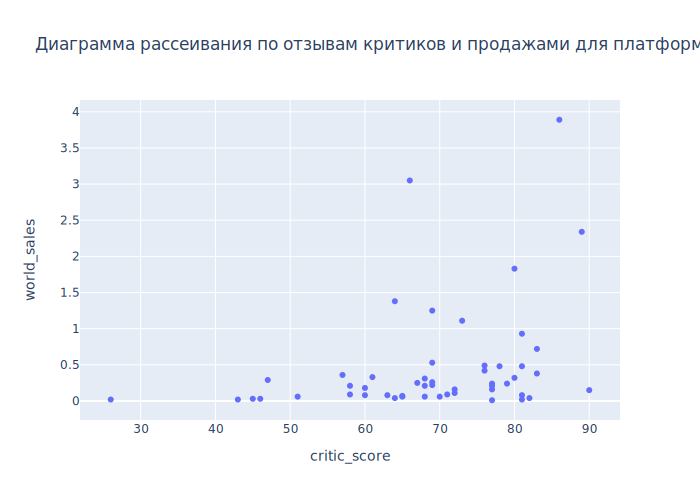

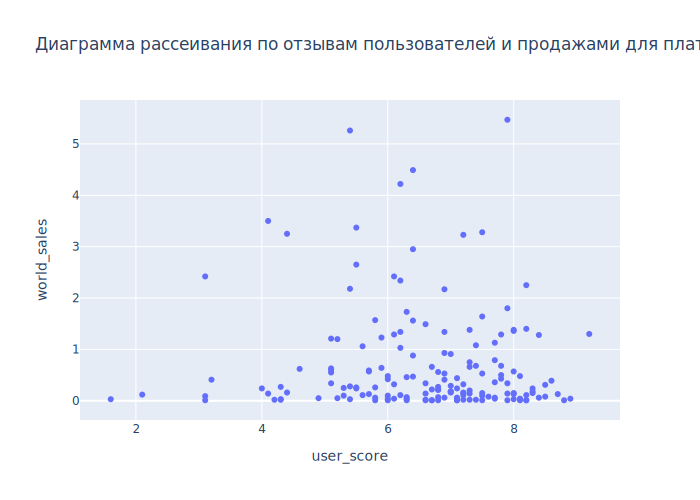

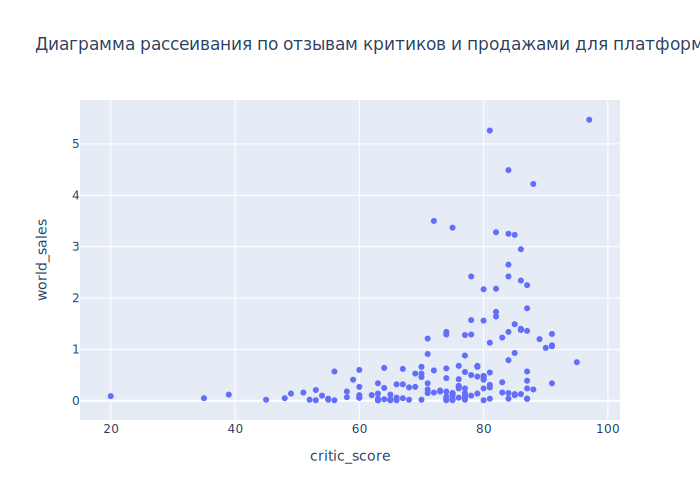

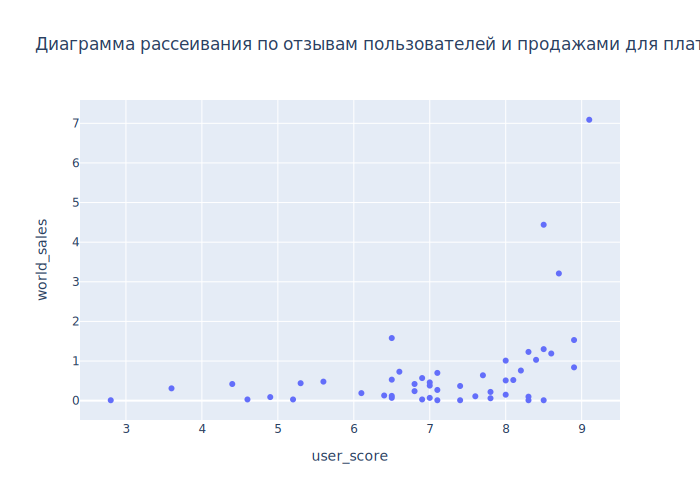

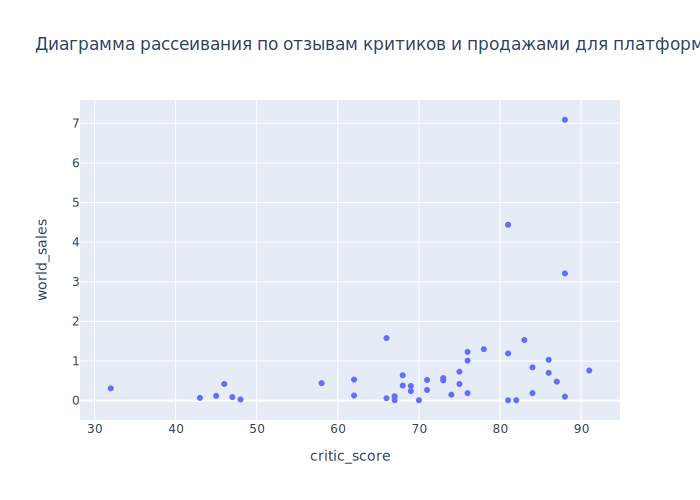

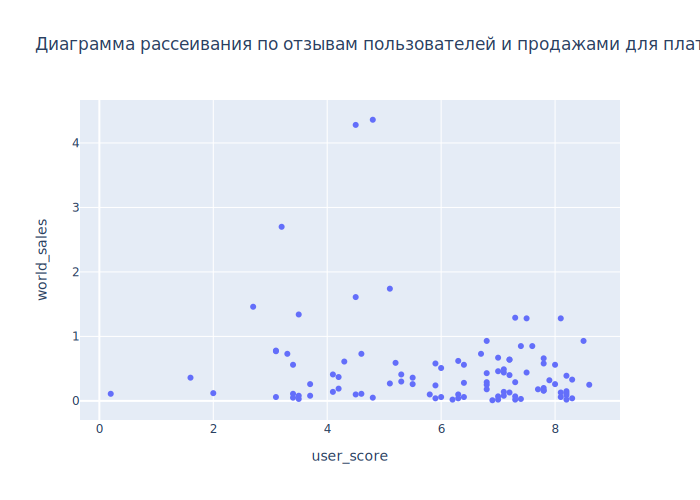

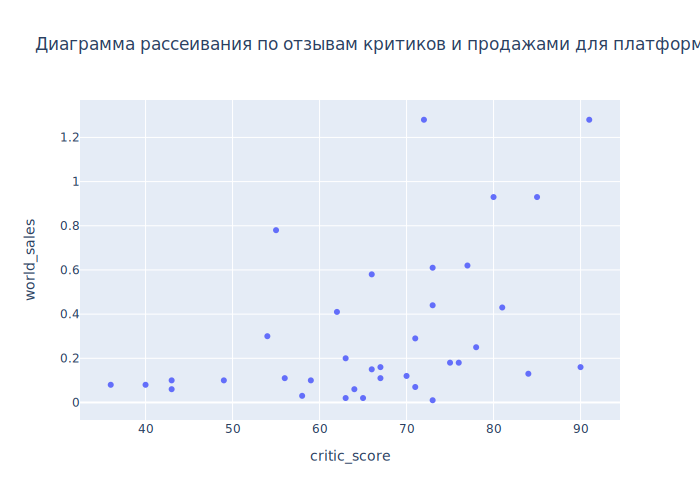

In [23]:
for i in dfa['platform'].unique()[:5]:
    pop_platform = dfa.query('platform == @i').sort_values(by='user_score')
    pop_platform_values_user = pop_platform.query('user_score != "unknown"')
    pop_platform_values_critic = pop_platform.query('critic_score != "unknown"')
    pop_platform_values_user['user_score'] = pop_platform_values_user['user_score'].astype(float)
    pop_platform_values_critic['critic_score'] = pop_platform_values_critic['critic_score'].astype(float) 
    
    fig = px.scatter(pop_platform_values_user, x="user_score", y="world_sales",
                 title=f'Диаграмма рассеивания по отзывам пользователей и продажами для платформы {i}')
    fig.show('svg')

    fig = px.scatter(pop_platform_values_critic, x="critic_score", y="world_sales",
                 title=f'Диаграмма рассеивания по отзывам критиков и продажами для платформы {i}')
    fig.show('svg')

In [24]:
for i in dfa['platform'].unique()[:5]:
    pop_platform = dfa.query('platform == @i').sort_values(by='user_score')
    pop_platform_values_user = pop_platform.query('user_score != "unknown"')
    pop_platform_values_critic = pop_platform.query('critic_score != "unknown"')
    pop_platform_values_user['user_score'] = pop_platform_values_user['user_score'].astype(float)
    pop_platform_values_critic['critic_score'] = pop_platform_values_critic['critic_score'].astype(float)
    
    print('----------')   
    
    print(f'Для платформы {i}:')
    
    print(f'Корреляция между отзывами пользователей и продажами платформы  равна', 
      pop_platform_values_user['user_score'].corr(pop_platform_values_user['world_sales']))

    print(f'Корреляция между отзывами критиков и продажами равна', 
      pop_platform_values_critic['critic_score'].corr(pop_platform_values_critic['world_sales']))

----------
Для платформы PS4:
Корреляция между отзывами пользователей и продажами платформы  равна -0.0401315894726973
Корреляция между отзывами критиков и продажами равна 0.4026614106810414
----------
Для платформы 3DS:
Корреляция между отзывами пользователей и продажами платформы  равна 0.21519327185270282
Корреляция между отзывами критиков и продажами равна 0.3141174928690509
----------
Для платформы XOne:
Корреляция между отзывами пользователей и продажами платформы  равна -0.07038392806475818
Корреляция между отзывами критиков и продажами равна 0.4286769437033323
----------
Для платформы WiiU:
Корреляция между отзывами пользователей и продажами платформы  равна 0.40792645792170795
Корреляция между отзывами критиков и продажами равна 0.370201412480884
----------
Для платформы PS3:
Корреляция между отзывами пользователей и продажами платформы  равна -0.16676141347662107
Корреляция между отзывами критиков и продажами равна 0.4465746049319072


#### Вывод

* Между отзывами пользователей и продажами слабая корреляция;
* Связь между отзывами критиков и продажами сильнее, чем отзывами пользователей.

### Популярность жанров

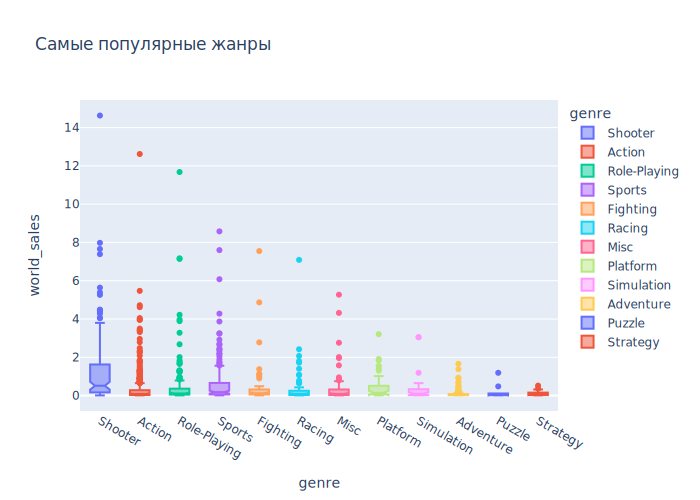

In [25]:
fig = px.box(dfa, x="genre", y="world_sales", color="genre", notched=True, title='Самые популярные жанры')
fig.show('svg')

#### Выводы

* Самым популярным жанром является Shooter с медианной прибыльностью в 0,515 млн
* Вторым по популярности жанр - Action
* Наименее популярный жанр - Adventures с медианной прибыльностью 0,03 млн

## Портрет пользователя каждого региона

### Популярные платформы

In [45]:
def pop_platform_region(df, columns, region):
    n = 0
    for col in columns:
        dff = df.pivot_table(index='platform', values=col, aggfunc='sum').sort_values(by=col, ascending=False).head(5).reset_index()
        fig = px.pie(dff, values=col, names='platform', title='Самые популярные платформы в ' + region[n])
        fig.show('svg')
        n+=1

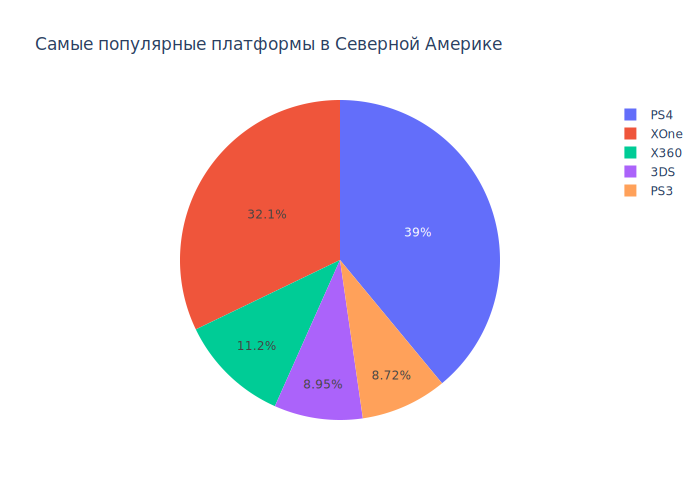

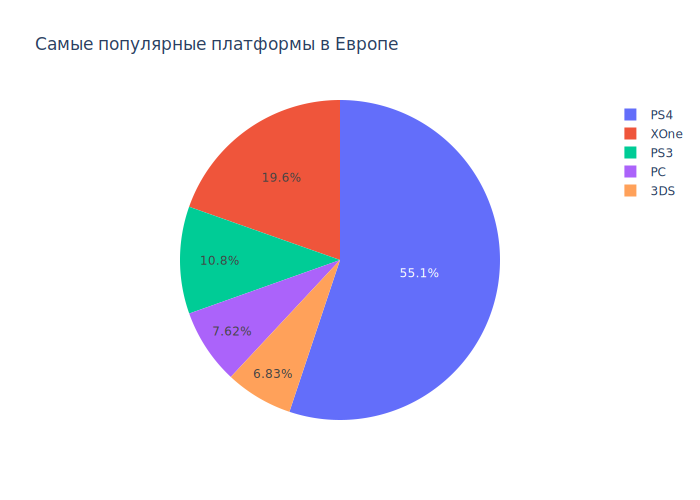

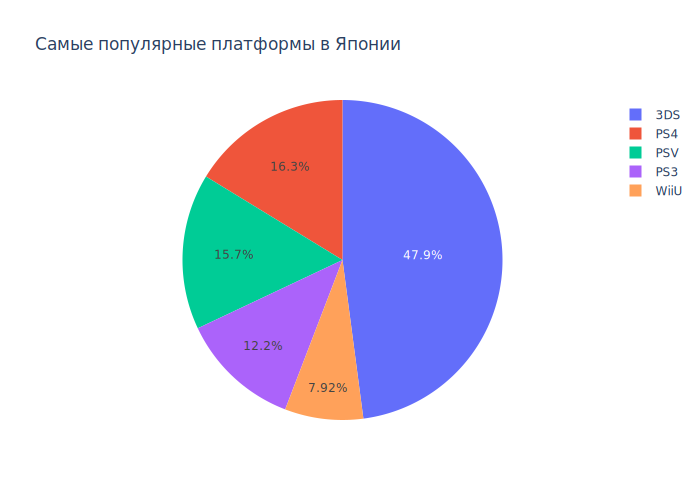

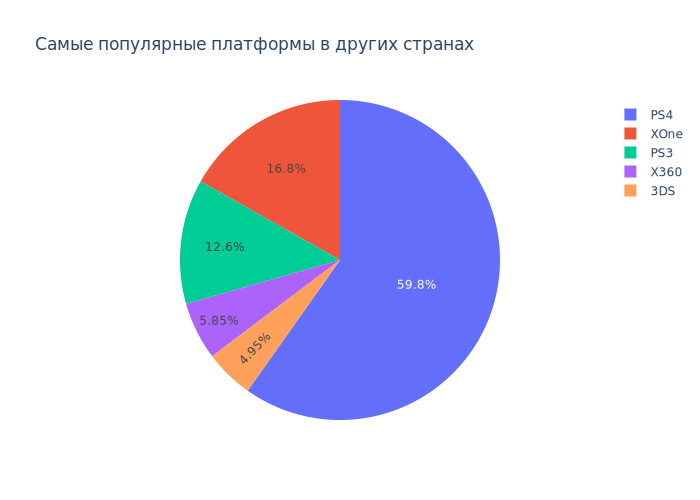

In [46]:
pop_platform_region(dfa, ['na_sales', 'eu_sales', 'jp_sales', 'other_sales'],
                 ['Северной Америке', 'Европе', 'Японии', 'других странах'])

#### Выводы

* Вновь для всех стран, кроме Японии самая популярная платформа - PS4;
* Самая популярная в Японии платформа - 3DS;
* Вторая по популярности платформа (кроме Японии) - XOne.

### Популярные жанры

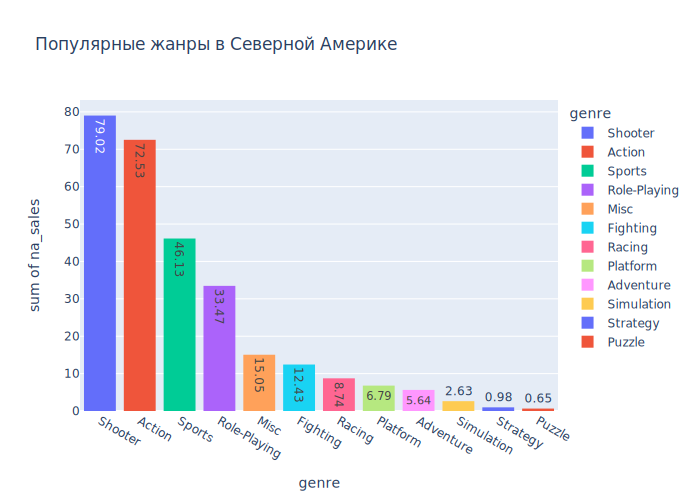

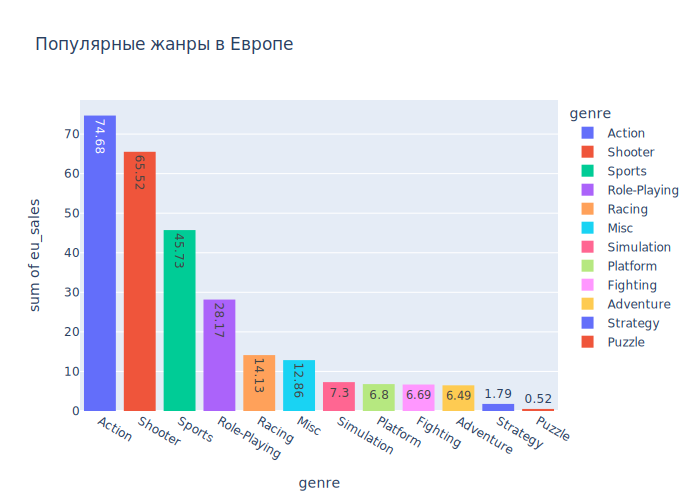

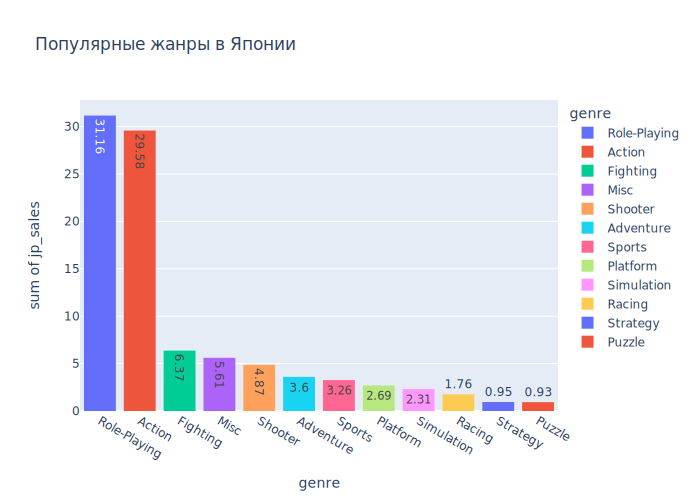

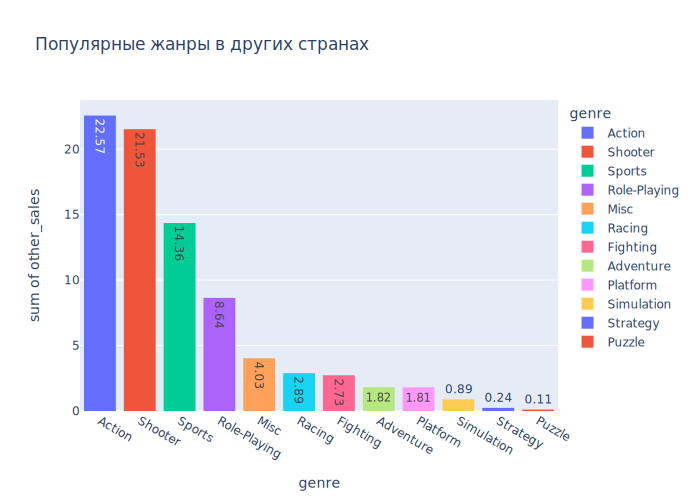

In [38]:
regions = ['na_sales', 'eu_sales', 'jp_sales', 'other_sales']
region_rus = ['Северной Америке', 'Европе', 'Японии', 'других странах']
j = 0

for i in regions:
    pop_jenre = dfa.groupby('genre') \
                       .agg({i: 'sum'}) \
                       .reset_index() \
                       .sort_values(by=i, ascending=False)
    fig = px.histogram(pop_jenre, x="genre", y=i, color="genre", title='Популярные жанры в ' + region_rus[j], text_auto=True)
    fig.show('svg')
    j+=1

#### Выводы

Культура стран в корне разная, отсюда и различия в популярности жанров. 

Для Северной Америки - Шутер, для Европы - Экшн, для Японии - Ролевые игры, для других стран - Экшн.

### Влияние рейтинга ESRB

In [29]:
def reting_region(df, columns, region):
    n = 0
    for col in columns:
        dff = df.pivot_table(index='rating', values=col, aggfunc='sum').sort_values(by=col, ascending=False).head(5).reset_index()
        fig = px.pie(dff, values=col, names='rating', title='Влияние рейтинга ESRB в ' + region[n])
        fig.show('svg')
        n+=1

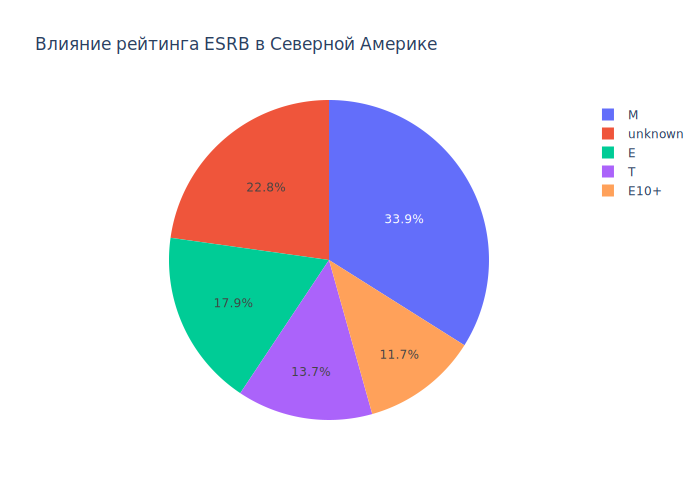

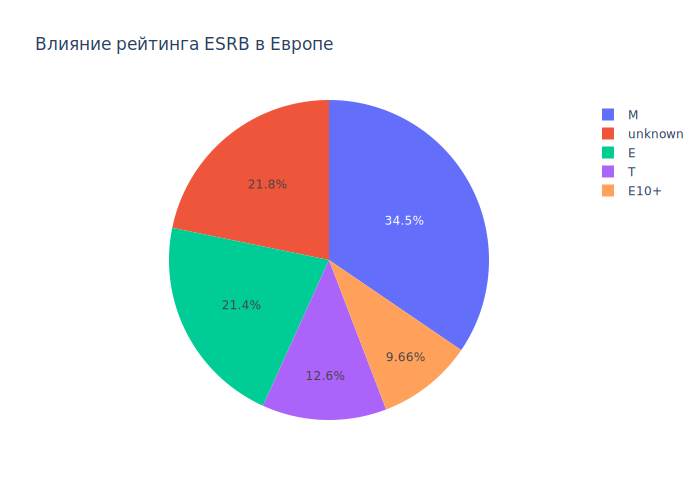

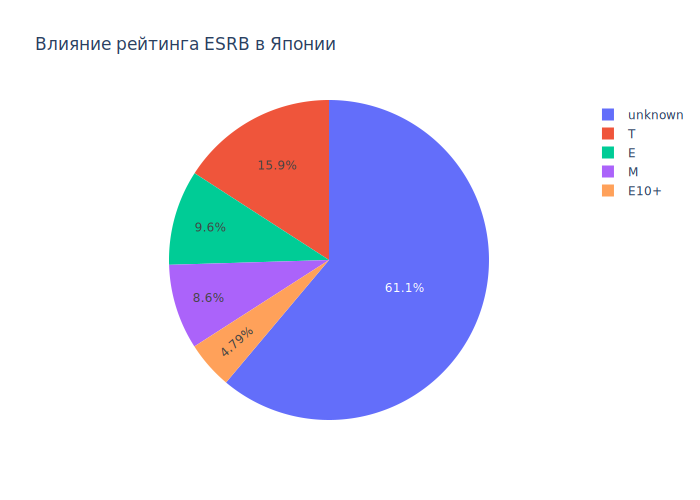

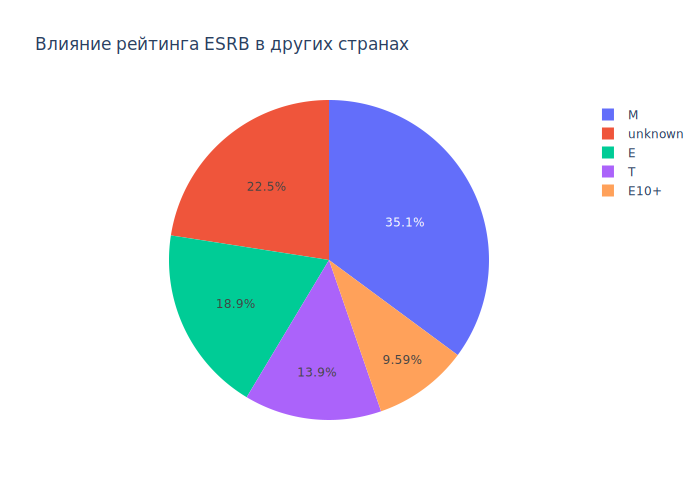

In [30]:
reting_region(dfa, ['na_sales', 'eu_sales', 'jp_sales', 'other_sales'],
                 ['Северной Америке', 'Европе', 'Японии', 'других странах'])

#### Выводы

- Рейтинг ESBR можно считать актуальным только для игр США и Канады;
- Для Японии же данный рейтинг не котируется (что и видно на графике), поскольку у них имеется свой.

## Проверка гипотез

- Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
- Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

**Введем нулевую и альтернативные гипотезы**:

$\begin{equation*}
 \begin{cases}
   H_0 :\text{Средние пользовательские рейтинги платформ Xbox One и PC одинаковы}\\
   H_1 :\text{Средние пользовательские рейтинги платформ Xbox One и PC различны}
 \end{cases}
\end{equation*}$

Уровень значимости: $\alpha = 0.05$

Рассчитаем p-value. Если p-value будет меньше выбранного уровня значимости ($\alpha = 0.05$), то будут основания отвергнуть нулевую гипотезу о равенстве средних в пользу альтернативной. Иначе сделаем вывод, что данные не позволили нам отвергнуть нулевую гипотезу.

In [31]:
clear_score = dfa.query('user_score != "unknown"')
clear_score['user_score'] = clear_score['user_score'].astype(float)

x_one = clear_score.query('platform == "XOne"')
pc = clear_score.query('platform == "PC"')

In [32]:
alpha = .05

results = stats.ttest_ind(x_one['user_score'], pc['user_score'], equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Имеются основания отвергнуть нулевую гипотезу')
else:
    print('Недостаточно оснований, чтобы отвергунть нулевую гипотезу')

p-значение: 0.11601398086668832
Недостаточно оснований, чтобы отвергунть нулевую гипотезу


#### Выводы

- С вероятностью 12% результат может быть получен случайно. Статистически значимые различия отсутствуют.
- На доступных данных на 1% уровне значимости недостаточно оснований, чтобы отвергнуть нулевую гипотезу в пользу альтернативной.
- Средние пользовательские рейтинги платформ Xbox One и PC одинаковы.

### Средние пользовательские рейтинги жанров Action и Sports разные

**Введем нулевую и альтернативные гипотезы**:

$\begin{equation*}
 \begin{cases}
   H_0 :\text{Средние пользовательские рейтинги жанров Action и Sports одинаковы}\\
   H_1 :\text{Средние пользовательские рейтинги жанров Action и Sports различны}
 \end{cases}
\end{equation*}$

Уровень значимости: $\alpha = 0.05$

Рассчитаем p-value. Если p-value будет меньше выбранного уровня значимости ($\alpha = 0.05$), то будут основания отвергнуть нулевую гипотезу о равенстве средних в пользу альтернативной. Иначе сделаем вывод, что данные не позволили нам отвергнуть нулевую гипотезу.

In [33]:
action_rat = clear_score.query('genre == "Action"')
sports_rat = clear_score.query('genre == "Sports"')

In [34]:
alpha = .05

results = stats.ttest_ind(action_rat['user_score'], sports_rat['user_score'], equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Имеются основания отвергнуть нулевую гипотезу')
else:
    print('Недостаточно оснований, чтобы отвергунть нулевую гипотезу')
    
print('Средний пользовательский рейтинг для жанра Action', action_rat['user_score'].mean())
print('Средний пользовательский рейтинг для жанра Sports', sports_rat['user_score'].mean())

p-значение: 1.1825550382644557e-14
Имеются основания отвергнуть нулевую гипотезу
Средний пользовательский рейтинг для жанра Action 6.760606060606054
Средний пользовательский рейтинг для жанра Sports 5.225196850393697


#### Выводы

- На доступных данных на 1% уровне значимости имеются основания отвергнуть нулевую гипотезу в пользу альтернативной.
- Обнаружены статистически значимые различия между выборками. Средние пользовательские рейтинги жанров Action и Sports не одинаковы.

## Общие выводы

- Наибольшими успехом и популярностью пользуется игровая платформа SonyPlastation 4. Её доходы и темпы продаж самые высокие;
- Невозможно однозначно дать характеристику самому популярному жанру в мире. У каждой страны свои ценности и интересы. Тем не менее, можно выделить среди прочих жанры Экшн или Шутер;
- Оценка критиков в должной мере влияет на объёмы продаж игр;
- Платформам свойственно уходить в "забвение" в связи с выходом более новых;
- 

**Рекомендации компании:**
- При разработке стратегии рекламной компании, для извлечения наибольшей прибыльности следует сделать упор на платформы SonyPlastation 4 или XBox One.
- При этом в качестве жанров игр рекомендуется взять Action - для Европы, Шутер - для Северной Америки, Role-Plaing - для Японии.